In [1]:
#@title Imports and Utilities

#standard
import numpy as np
import scipy
import xgboost as xgb
import pandas as pd
import os

#ML
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

#utils
from functools import partial

#plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

def get_data():
    df = pd.read_csv('F:/xgboost/data/data.csv') #返回一个DataFrame的对象，这个是pandas的一个数据结构
    df.columns=["Col1","Col2"]
    X1 = df[["Col1"]] #抽取前七列作为训练数据的各属性值
    X = np.array(X1)
    y1 = df["Col2"] #最后一列作为每行对应的标签label
    #Y = df["Col8"].map(lambda y1:float(y1.rstrip(";")))
    y = np.array(y1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=X)
    
    train = np.c_[X_train,y_train]
    train = train[np.argsort(train[:,0])]
    X_train=train[:,0]
    
    y_train=train[:,1].ravel()
    X_train = np.array(X_train).reshape(1, -1).T
    
    
    test = np.c_[X_test,y_test]
    test = test[np.argsort(test[:,0])]
    X_test=test[:,0]
    y_test=test[:,1].ravel()
    X_test=np.array(X_test).reshape(1,-1).T
    return X_train,y_train,X_test,y_test

def collect_prediction(X_train,y_train,X_test,y_test,estimator,alpha,model_name):
  estimator.fit(X_train,y_train) #训练算法，设置内部参数。接收训练集和类别两个参数。
  y_pred = estimator.predict(X_test)#预测测试集类别，参数为测试集。
  print( "{model_name} alpha = {alpha:.2f},score = {score:.1f}".format(model_name=model_name, alpha=alpha , score= XGBQuantile.quantile_score(y_test, y_pred, alpha)) )
  return y_pred

def plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower):
  
  #plt.plot(X_test,y_test, 'g:', label=u'$f(x) = x\,\sin(x)$')
  plt.plot(X_train,y_train, 'b.', markersize=10, label=u'Observations')
  plt.plot(X_test, y_pred, 'r-', label=u'Prediction')
  plt.plot(X_test, y_upper, 'k-',markersize=10,label=u'upper')
  plt.plot(X_test, y_lower, 'k-',markersize=10)
  plt.fill(np.concatenate([X_test, X_test[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
  plt.xlabel('$x$')
  plt.ylabel('$f(x)$')
  plt.xlim(100 , 10000)
  plt.ylim(-1000 , 80000)
  plt.legend(loc='upper left')


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
class XGBQuantile(XGBRegressor):#XGBQuantile类的父类是XGBRegressor
    #带两个下划线开头的函数是声明该属性为私有，不能在外部被使用或直接访问
  def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
      #_init_函数支持带参数的类的初始化，也可为声明该类的属性
    self.quant_alpha = quant_alpha
    self.quant_delta = quant_delta
    self.quant_thres = quant_thres
    self.quant_var = quant_var
    
    super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
       colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
       max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
       n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
       silent=silent, subsample=subsample)
      #super是在子类中调用父类的初始化方法
    
    self.test = None
  
  def fit(self, X, y):
    super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
    super().fit(X,y)
    return self
  
  def predict(self,X):
    return super().predict(X)
  
  def score(self, X, y):
    y_pred = super().predict(X)
    score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
    score = 1./score
    return score
      
  @staticmethod #静态方法
  def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
    grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
    hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
    return grad, hess
  
  @staticmethod
  def original_quantile_loss(y_true,y_pred,alpha,delta):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    return grad,hess

  
  @staticmethod
  def quantile_score(y_true, y_pred, alpha):
    score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
    score = np.sum(score)
    return score
  
  @staticmethod
  def quantile_cost(x, alpha):
    return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
  @staticmethod
  def get_split_gain(gradient,hessian,l=1):
    split_gain = list()
    for i in range(gradient.shape[0]):
      split_gain.append(np.sum(gradient[:i])/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])/(np.sum(hessian[i:])+l)-np.sum(gradient)/(np.sum(hessian)+l) )
    
    return np.array(split_gain)


Gradient Boosting alpha = 0.05,score = 90726.6
Gradient Boosting alpha = 0.95,score = 86627.5
[10:13:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Quantile XGB alpha = 0.05,score = 607521.6
Quantile XGB alpha = 0.95,score = 11542979.3


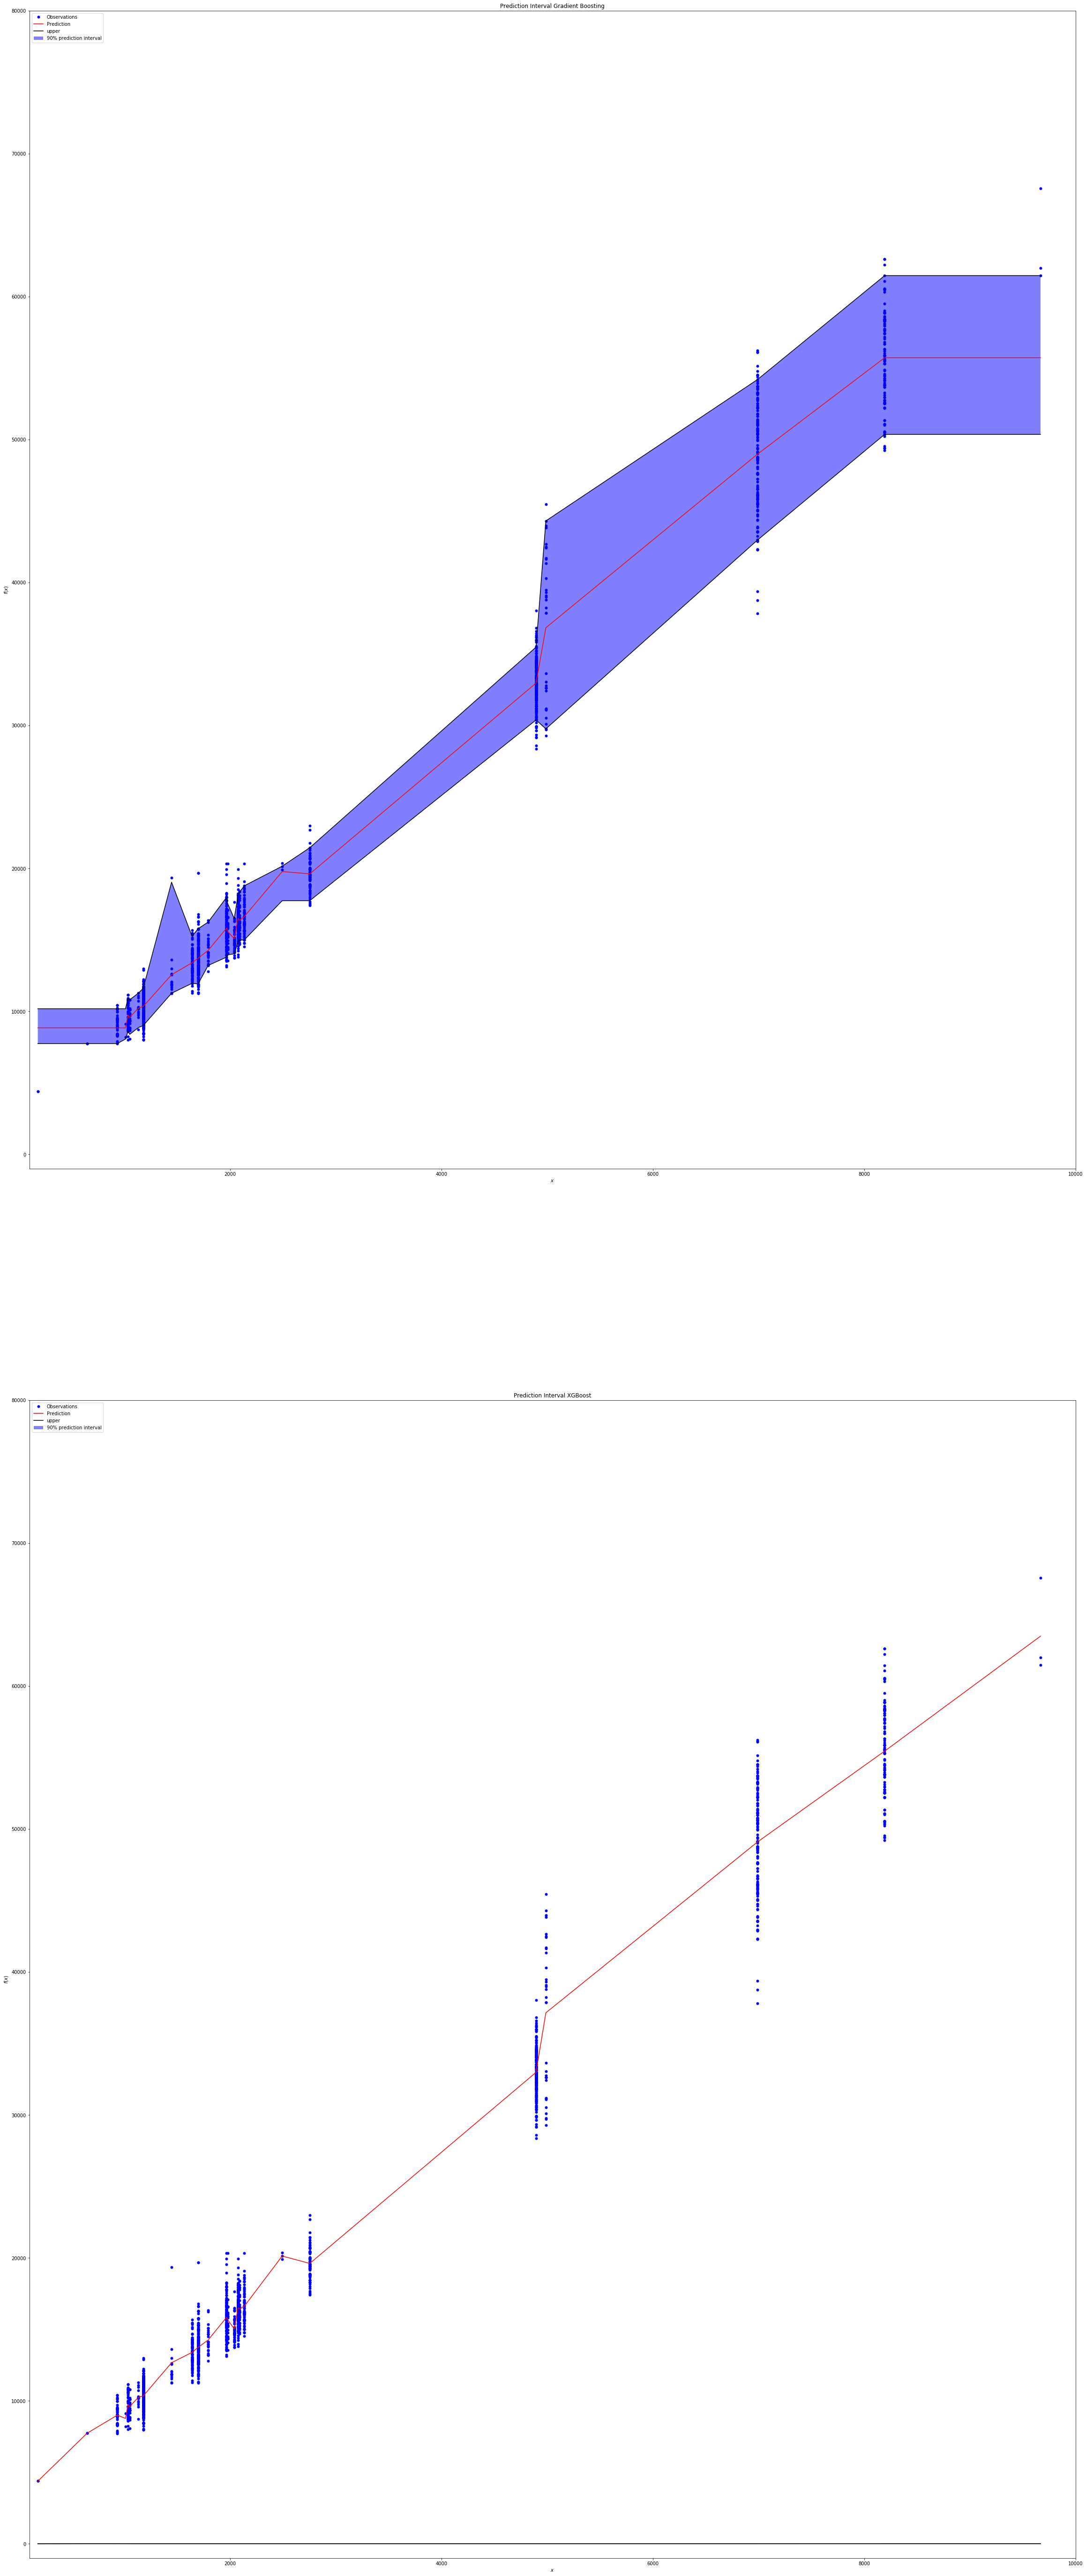

In [3]:
alpha = 0.95 #@param {type:"number"}

X_train,y_train,X_test,y_test = get_data()

regressor = GradientBoostingRegressor(n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
y_pred = regressor.fit(X_train,y_train).predict(X_test)
regressor.set_params(loss='quantile', alpha=1.-alpha)
y_lower = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=1.-alpha,model_name="Gradient Boosting")
regressor.set_params(loss='quantile', alpha=alpha)
y_upper = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=alpha,model_name="Gradient Boosting")

                                                                 
fig = plt.figure(figsize=(40,100))

plt.subplot(211)
plt.title("Prediction Interval Gradient Boosting")
plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower)


regressor = XGBRegressor(n_estimators=700,max_depth=5,reg_alpha=0.1, reg_lambda=0.1,gamma=0.4,min_child_weight=1,colsample_bytree=0.6,subsample=0.7,learning_rate=0.2)#n_estimators=250弱学习器最大迭代次数
y_pred = regressor.fit(X_train,y_train).predict(X_test)

regressor = XGBQuantile(n_estimators=100,max_depth = 3, reg_alpha =0.1,gamma = 0.5,reg_lambda =1.0)    
regressor.set_params(quant_alpha=1.-alpha,quant_delta=9.5,quant_thres=7.0,quant_var=4.8)
y_lower = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=1.-alpha,model_name="Quantile XGB")
regressor.set_params(quant_alpha=alpha,quant_delta=9.9,quant_thres=8.1,quant_var = 7.8)
y_upper = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=alpha,model_name="Quantile XGB")

plt.subplot(212)
plt.title("Prediction Interval XGBoost")
plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower)

In [4]:
# X_train,y_train,_,_ = get_data()
# 
# estimator = XGBQuantile(quant_alpha = 0.95,quant_delta= 5.0, quant_thres = 5.0 ,quant_var=4.0)
# 
# gs  = RandomizedSearchCV(estimator = estimator, 
#                         param_distributions={
#                                   'quant_delta':scipy.stats.uniform(0.01,10.0),
#                                   'quant_var':scipy.stats.uniform(1.0,10.0),
#                                   'quant_thres':scipy.stats.uniform(0.01,10.0)
#                         },n_iter=200,cv=5,iid=True,return_train_score =False)
# 
# gs.fit(X_train,y_train)
# 
# print(
# pd.DataFrame(gs.cv_results_).loc[:5,['mean_test_score','std_test_score','param_quant_delta','param_quant_thres','param_quant_var']]
# )



